# eqGAN Evaluation Notebook

An attempt to perform automatic music mastering using a Generative Adversarial Network

### Make sure that these constants are set correctly! (Need to be the same as those run in Training.ipynb)

In [1]:
# Constants
USING_GPU = True
AVAILABLE_GPUS="8"
CUDANO = 8

LR = 1e-3
EPOCHS = 10
IS_DIRECT = True # Direct or Indirect Reconstruction (See Paper for more details)
SAMPLE_LENGTH = 110229 # Less than 661794


RUN_NAME = 'example_run_1'

You should (hopefully) be able to run the rest of the cells without editing anything

In [1]:
import torch
import torchaudio
import requests
import matplotlib.pyplot as plt
import numpy as np

/lfs/turing2/0/frg100/gpuvenv/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Download the dataset

In [2]:
# Construct a torch.utils.data.Dataset and DataLoader
gtzan_data = torchaudio.datasets.GTZAN('.', download=False)
gtzan_loader = torch.utils.data.DataLoader(gtzan_data, batch_size=1, shuffle=False, num_workers=6)

In [3]:
def visualize_wav(waveform, domain='time'):
    """
    A function to visualize a waveform in the time or frequency domain
    """
    wav = torch.squeeze(waveform, dim=0)
    if domain == 'freq':
        plt.figure(figsize=(50,30))
        specgram = torchaudio.transforms.Spectrogram()(wav)
        plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')
    elif domain == 'time':
        plt.figure()
        plt.plot(wav.t().numpy())
    else:
        print('Invalid domain')

Shape of waveform: torch.Size([1, 1, 661794])
Sample rate of waveform: tensor([22050])


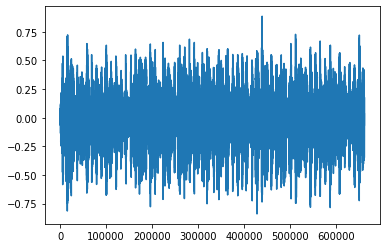

In [4]:
# Show a single example
example_wav, example_sr = None, None
for waveform, sample_rate, label in gtzan_loader:
    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))
    example_wav, example_sr = waveform, sample_rate

    visualize_wav(waveform)
    break

### Implement EQ operations

In [55]:
# Define the EQ transform
from scipy.stats import loguniform

class RandomEQ(object):
    """EQ the waveform in a sample randomly.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, sample_rate):
        assert isinstance(sample_rate, (float, int))
        self.sample_rate = sample_rate
        
        # EQ Constants
        self.FREQ_RANGE = [0.01, 20] # in kHZ
        self.GAIN_RANGE = [-15, 15] # in dB
        self.Q_RANGE = [0.1, 18]

    def __call__(self, waveform, verbose=False):
        # TODO: Make some of these normals
        center_freq = loguniform.rvs(self.FREQ_RANGE[0], self.FREQ_RANGE[1])
        gain = np.random.uniform(self.GAIN_RANGE[0], self.GAIN_RANGE[1])
        Q = np.random.uniform(self.Q_RANGE[0], self.Q_RANGE[1])

        center_freq = 1
        gain = -10
        Q = 1
        
        if verbose:
            print(
                f"Applying random EQ with center frequency of ",
                f"{center_freq} kHZ, gain of {gain} dB, and Q = {Q}"
            )

        equalized_waveform = torchaudio.functional.equalizer_biquad(
            waveform, self.sample_rate,
            center_freq=center_freq*1e3, gain=gain, Q=Q
        ) 

        return equalized_waveform

Shape of waveform: torch.Size([1, 1, 661794])
Sample rate of waveform: tensor([22050])


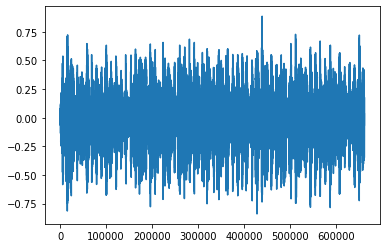

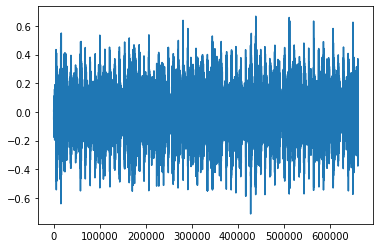

In [56]:
# Show a single example
eq_transform = RandomEQ(int(example_sr[0]))
for waveform, sample_rate, label in gtzan_loader:
    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    visualize_wav(waveform)
    visualize_wav(eq_transform(waveform))
    break

### Learn an EQ operation

We want to test whether or not we can have a model learn an EQ operation by reconstructing the non-equalized version of the waveform

In [77]:
import os

device = 'cpu'

if USING_GPU:
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]=AVAILABLE_GPUS
    device = f'cuda:{CUDANO}'

In [86]:
class EQReconstructor(torch.nn.Module):
    def __init__(self, sample_rate, sample_length, direct=False):
        """
        In the constructor we instantiate the layers
        """
        super().__init__()
        self.sample_rate = sample_rate
        self.sample_length = sample_length
        self.direct = direct
        self.indirect = not direct

        self.synthetic_transform = RandomEQ(self.sample_rate)
        self.indirect_rnn = torch.nn.LSTM(input_size=1, hidden_size=3, num_layers=1)
        self.direct_rnn = torch.nn.LSTM(input_size=1, hidden_size=1, num_layers=1)
        
        #self.gain = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.gain_min = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.gain_max = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.gain_mean = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.gain_rmse = torch.nn.parameter.Parameter(torch.tensor(1.0))

        self.criterion = torch.nn.MSELoss()
        
        self.activation = torch.nn.Tanh()

    def forward(self, waveform):
        """
        In the forward function we accept an input waveform, apply a random
        EQ, and then try to reconstruct it
        """
        # print("Pre-processing wav")
        with torch.no_grad():
            equalized_wav = self.synthetic_transform(waveform)

        if self.direct:
            # Run through the rnn
            output, (hn, cn) = self.direct_rnn(equalized_wav)
            
            # Get some stats from the output to figure out how much to boost gain            
            gain = output.min()*self.gain_min + output.max()*self.gain_max + output.mean()*self.gain_mean + torch.pow(output, 2).mean()*self.gain_rmse
            
            # Boost the gain
            reconstructed_wav = output*gain
            
            return reconstructed_wav

        if self.indirect:
            # print("Sharding waveform")
            wav_length = waveform.shape[0]
            num_seconds = 5
            num_shards = int(wav_length / (self.sample_rate*num_seconds)) + 1

            center_freq = torch.tensor(0., requires_grad=True)
            gain = torch.tensor(0., requires_grad=True)
            Q = torch.tensor(0., requires_grad=True)
            for i in range(num_shards):
                # print(f"Running LSTM on shard {i+1}/{num_shards}")
                # Create shard
                start_idx = i*self.sample_rate
                end_idx = (i+1)*self.sample_rate
                if end_idx >= wav_length:
                    end_idx = -1
                shard = equalized_wav[start_idx:end_idx,:,:]

                # Run LTSM
                output, (hn, cn) = self.indirect_rnn(shard)

                # Add vals to running sum
                center_freq = center_freq + hn[0,0,0]
                gain = gain + hn[0,0,1]
                Q = Q + hn[0,0,2]

            # Divide by number of runs
            center_freq /= num_shards
            gain /= num_shards
            Q /= num_shards

            print(
                f"Predicted EQ with center frequency of ",
                f"{center_freq} kHZ, gain of {gain} dB, and Q = {Q}"
            )

            return center_freq, gain, Q

    def loss(self, output, waveform):
        """
        Here we define the loss function that the model will try to optimize.
        In this case, a simple reconstruction loss
        """
        if direct:
            reconstructed_wav = output
        if indirect:
            center_freq, gain, Q = output
            reconstructed_wav = torchaudio.functional.equalizer_biquad(
                waveform, self.sample_rate,
                center_freq=center_freq*1e3, gain=gain, Q=Q
            )
        loss = criterion(waveform, reconstructed_wav)
        return loss


In [87]:
criterion = torch.nn.MSELoss()
def loss_function(output, waveform, direct=False):
    """
    Here we define the loss function that the model will try to optimize.
    In this case, a simple reconstruction loss
    """
    if direct:
        reconstructed_wav = output
    if not direct:
        center_freq, gain, Q = output
        reconstructed_wav = torchaudio.functional.equalizer_biquad(
            waveform, self.sample_rate,
            center_freq=center_freq*1e3, gain=gain, Q=Q
        )
    loss = criterion(waveform, reconstructed_wav)
    loss += torch.pow(waveform.max() - reconstructed_wav.max(), 2) # Penalize differences in max
    loss += torch.pow(waveform.min() - reconstructed_wav.min(), 2)# Penalize differences in min
    return loss

In [92]:
num_gpus = torch.cuda.device_count()
    
for i in range(num_gpus):
    print("Device ", i, torch.cuda.get_device_name(i))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(i)/1024**3,1), 'GB')
    
# print(os.popen("source cuda10.0").read())

# print(os.popen("nvidia-htop.py").read())
# print(os.popen("nvidia-smi").read())

Let's use 6 GPUs!
Device  0 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Device  1 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Device  2 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Device  3 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Device  4 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Device  5 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
checkpoint_path = f'./f{RUN_NAME}.pt'

In [ ]:
def load_checkpoint(path):
    checkpoint = torch.load(path)
    model = EQReconstructor(
        sample_rate=checkpoint["hyperparameters"]["sample_rate"],
        sample_length=checkpoint["hyperparameters"]["sample_length"],
        direct=checkpoint["hyperparameters"]["direct"]
    ).to(f'cuda:{CUDANO}')
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
    optimizer = torch.optim.SGD(model.parameters(), lr=checkpoint['hyperparameters']['lr'])
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['opt'])
    
    return model, optimizer, checkpoint['losses']

In [ ]:
model, optimizer, losses = load_checkpoint(checkpoint_path)

if num_gpus > 1:
    print("Let's use", num_gpus , "GPUs!")
    model = torch.nn.DataParallel(model)

In [ ]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Epoch Loss on GTZAN 5-second examples, {EPOCHS} Epochs')
plt.savefig('gtzan_5_sec_10_epochs_sample_loss.png')

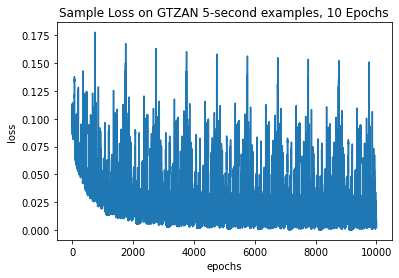

In [67]:
plt.plot(full_losses)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title(f'Sample Loss on GTZAN 5-second examples, {EPOCHS} Epochs')
plt.savefig('gtzan_5_sec_10_epochs_sample_loss.png')